# DNN Practical: Ag Detection by Muon Spectroscopy

In this notebook, we attempt to solve a real problem in physics using a fully connected DNN.

We have a set of spectra from Muon spectroscopy experiments, from which we would like to detect whether or not a certain element is present in a sample. In this notebook, we are going to train a neural network to detect the presence of Ag. Through this practice, we will encounter and overcome a pitfall in deep learning known as **class imbalance**. We will also explore **early stopping** and saving checkpoints from the best performing model.

In [1]:
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# check version
print('Using TensorFlow v%s' % tf.__version__)
acc_str = 'accuracy' if tf.__version__[:2] == '2.' else 'acc'

# helpers
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# need some certainty in data processing
np.random.seed(0)

Using TensorFlow v2.3.1


## Google Cloud Storage Boilerplate

The following two cells have some boilerplate to mount the Google Cloud Storage bucket containing the data used for this notebook to your Google Colab file system. To access the data, you need to:

1. Run the first cell;
2. Follow the link when prompted (you may be asked to log in with your Google account);
3. Copy the Google SDK token back into the prompt and press `Enter`;
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called `sciml-workshop-data` should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will take no effect.

In [2]:
# variables passed to bash; do not change
project_id = 'sciml-workshop'
bucket_name = 'sciml-workshop'
colab_data_path = '/content/sciml-workshop-data/'

try:
    from google.colab import auth
    auth.authenticate_user()
    google_colab_env = 'true'
    data_path = colab_data_path
except:
    google_colab_env = 'false'
    ###################################################
    ######## specify your local data path here ########
    ###################################################
    data_path = './sciml-workshop-data/'

In [3]:
%%bash -s {google_colab_env} {colab_data_path} {project_id} {bucket_name}

# running locally
if ! $1; then
    echo "Running notebook locally."
    exit
fi

# already mounted
if [ -d $2 ]; then
    echo "Data already mounted."
    exit
fi

# mount the bucket
echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
apt -qq update
apt -qq install gcsfuse
gcloud config set project $3
mkdir $2
gcsfuse --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 $4 $2

Running notebook locally.


---

# The dataset

### Read raw data

The raw data, which include the constituent elements and the Muon spectra of the samples, are stored in the pickle file `muon/Ag_muon_data.pkl`. We load this file into a `pandas` dataframe and take a quick look.

In [4]:
# read data
df = pd.read_pickle(data_path + 'muon-data/ag-muon-data-tight.pkl')
#print dimensions
print('Number of samples in the dataset: %d' % len(df['Spectra']))
print('Length of spectra for each sample: %d' % len(df['Spectra'][0]))

# print the first few data
df.head(n=5)

Number of samples in the dataset: 138613
Length of spectra for each sample: 1000


,Elements,oh,c,Spectra
8877,"[Si, Fe, Sb, Bi]",0,"[0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 132.19327401887..."
88555,"[Sb, Fe, Bi]",0,"[0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 106.91719527298..."
111153,"[Si, Sb]",0,"[0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 108.04741040971..."
27279,"[Fe, Cu, Bi]",0,"[0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 106.84704457348..."
26419,"[Si, Fe]",0,"[0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 100.82180543319..."


In the above table, the `Elements` and the `Spectra` columns show respectively the elements and the spectra of the samples. There are 138,613 samples in the dataset, and each spectrum is a series of 1000 positive reals. 

To get a feel for the complexity of picking out signals with Ag in multinary samples, we can plot some random spectra for three representative cases: 

* no Ag
* pure Ag
* Ag-Si binary

Note that we are plotting only the first part of each spectrum. Change `[0:150]` to `[:]` to show the full spectra.

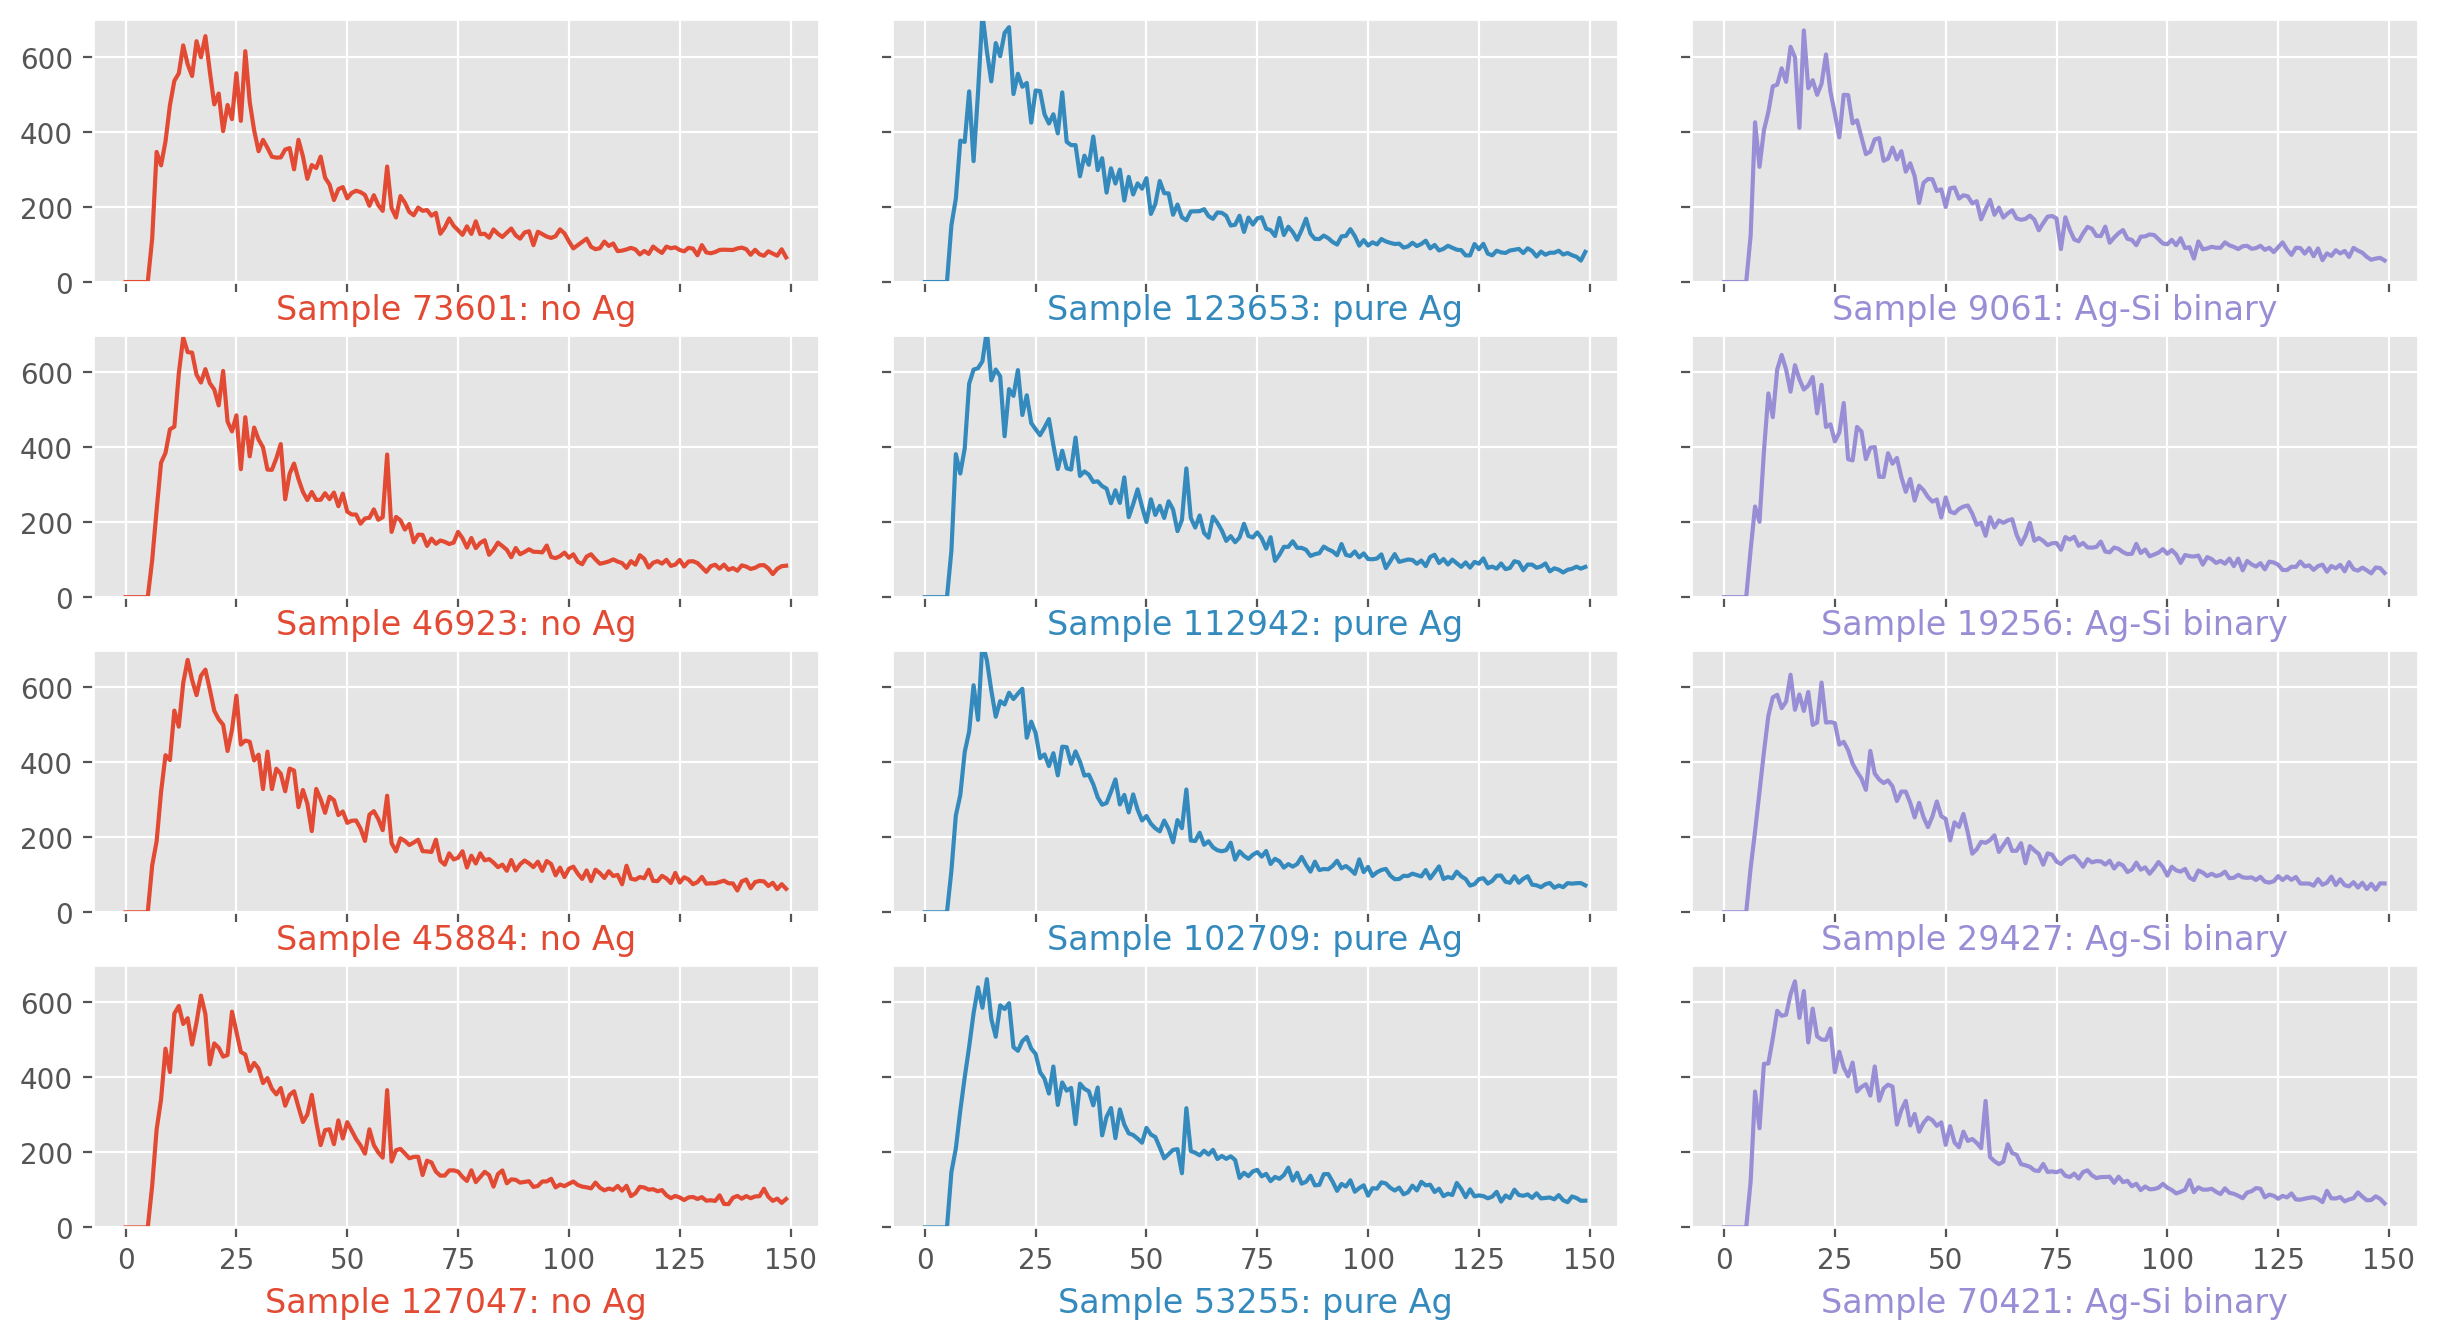

In [5]:
# conditions to select data
conditions = [
# no Ag
('no Ag', np.where(['Ag' not in elements for elements in df['Elements']])[0]),
# pure Ag
('pure Ag', np.where([['Ag'] == elements for elements in df['Elements']])[0]),
# Ag-Si
('Ag-Si binary', np.where([['Ag', 'Si'] == elements for elements in df['Elements']])[0])
]

# plot
ncond = len(conditions)
nplot = 4 # number of plots per condition
fig, axs = plt.subplots(nplot, ncond, dpi=200, figsize=(ncond * 5, nplot * 2), sharex=True, sharey=True)
plt.subplots_adjust(wspace=.1, hspace=.2)
for icond, cond in enumerate(conditions):
    for iplot, idata in enumerate(np.random.choice(cond[1], nplot)):
        axs[iplot, icond].plot(df['Spectra'][idata][0:150], c='C%d' % icond)
        axs[iplot, icond].set_xlabel('Sample %d: %s' % (idata, cond[0]), c='C%d' % icond)
        axs[iplot, icond].set_ylim(0, 700)

### Extract training data

The input data for our network will be the `Spectra` column, and we can use the `to_list()` method to convert it to a numpy array. The output data for our network will be a binary-valued one-hot vector: 0 for no Ag in the sample and 1 otherwise. One-hot encoding can be achieved by a simple for-loop. Also, it is important to normalise each spectrum between 0 and 1.

In [6]:
###### input ######
# convert the 'Spectra' column to numpy
train_x = np.array(df['Spectra'].to_list())
# normalise each spectrum to [0, 1]
train_x /= np.max(train_x, axis=1)[:, np.newaxis]

###### output ######
# one-hot encoding: whether Ag is in 'Elements'
train_y = np.array(['Ag' in elements for elements in df['Elements']]).astype(int)

# print data shapes
print("Shape of input: %s" % str(train_x.shape))
print("Shape of output: %s" % str(train_y.shape))

Shape of input: (138613, 1000)
Shape of output: (138613,)


---

# Ag-detection by DNN

## 1. Try out a network


### Build and compile

Based on what we have learnt in [03_DNN_basics.ipynb](03_DNN_basics.ipynb), design a simple neural network with `Dense` layers to detect Ag in the spectra. In general, it is not a straightforward task to determine the number of hidden layers and the number of neurons in each layer, which usually involves some trial and error. In this case, our output size is 1, so we'd better add a small layer before it, such as one with size 16; then we upscale the size from 16 to 64.

Next, compile the model. We can keep using `adam` for the `optimizer` and `['accuracy']` for the `metrics`. For the `loss`, since we are fitting to a range between 0 and 1, we can choose `binary_crossentropy`.


**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# define the model
model = Sequential()
model.add(Dense(64, input_dim=1000, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# print model summary
model.summary()

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
```
    
</p>
</details>


In [7]:
# define the model
model = Sequential()
model.add(Dense(64, input_dim=1000, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# print model summary
model.summary()

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                64064     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 65,121
Trainable params: 65,121
Non-trainable params: 0
_________________________________________________________________


### Train the model

Since we have not separated a subset of data for validation, we can pass `validation_split=0.2` to `model.fit()`, which then will use the *final* 20% of the dataset for validation. Let us do 10 epochs first.


**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# train the model
training_history = model.fit(train_x, train_y, epochs=10, batch_size=64, 
                             validation_split=0.2)
```
    
</p>
</details>

In [8]:
# train the model
training_history = model.fit(train_x, train_y, epochs=10, batch_size=64, 
                             validation_split=0.2)

Epoch 1/10
1733/1733 [==============================] - 2s 1ms/step - loss: 0.2606 - accuracy: 0.9280 - val_loss: 0.2660 - val_accuracy: 0.9254
Epoch 2/10
1733/1733 [==============================] - 2s 1ms/step - loss: 0.2575 - accuracy: 0.9285 - val_loss: 0.2634 - val_accuracy: 0.9254
Epoch 3/10
1733/1733 [==============================] - 2s 1ms/step - loss: 0.2563 - accuracy: 0.9285 - val_loss: 0.2619 - val_accuracy: 0.9254
Epoch 4/10
1733/1733 [==============================] - 2s 1ms/step - loss: 0.2539 - accuracy: 0.9285 - val_loss: 0.2594 - val_accuracy: 0.9254
Epoch 5/10
1733/1733 [==============================] - 2s 1ms/step - loss: 0.2489 - accuracy: 0.9285 - val_loss: 0.2474 - val_accuracy: 0.9254
Epoch 6/10
1733/1733 [==============================] - 2s 1ms/step - loss: 0.2224 - accuracy: 0.9288 - val_loss: 0.1923 - val_accuracy: 0.9257
Epoch 7/10
1733/1733 [==============================] - 2s 1ms/step - loss: 0.1581 - accuracy: 0.9434 - val_loss: 0.1252 - val_accuracy:

### Plot training history

For convenience, we define a function to plot a training history:

In [9]:
# a function to plot training history
def plot_history(training_history):
    # plot accuracy
    plt.figure(dpi=100, figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(training_history.history[acc_str], label='Accuracy on training data')
    plt.plot(training_history.history['val_' + acc_str], label='Accuracy on test data')
    plt.legend()
    plt.title("Accuracy")

    # plot loss
    plt.subplot(1, 2, 2)
    plt.plot(training_history.history['loss'], label='Loss on training data')
    plt.plot(training_history.history['val_loss'], label='Loss on test data')
    plt.legend()
    plt.title("Loss")
    plt.show()

Now, plot the training history of the current model. They will look bizarre at this stage, as explained in the forthcoming section.

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# plot training history
plot_history(training_history)
```
    
</p>
</details>

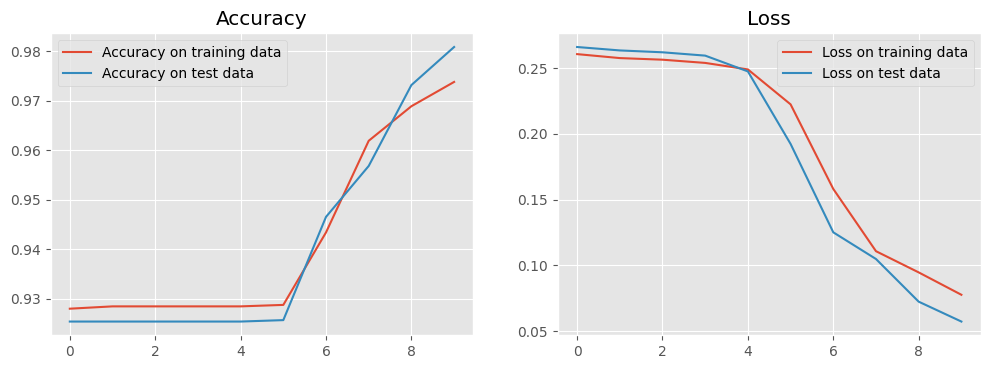

In [10]:
# plot training history
plot_history(training_history)

## 2. Class imbalance

In the above history plot, notice how the accuracy of the model converges to a high value very quickly (>90% at the end of the first epoch). Such an odd history indicates that something could be wrong within our dataset.

### Data distribution

Let us inspect the distribution of the data using `plt.hist(train_y)`, paying special attention to the validation part (the final 20%).

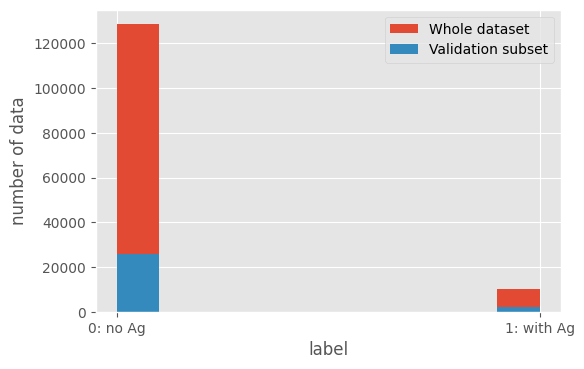

In [11]:
# plot distribution of data
plt.figure(dpi=100)
plt.hist(train_y, label='Whole dataset')
plt.hist(train_y[-len(train_y)//5:], label='Validation subset')
plt.xticks([0, 1], ['0: no Ag', '1: with Ag'])
plt.xlabel('label')
plt.ylabel('number of data')
plt.legend()
plt.show()

The histograms show that our dataset is dominated by samples labelled 0 or "no Ag", which account for over 95% of the data. Thus, if the model simply learns to *guess* "no Ag" in every sample, it can achieve 95% accuracy without learning anything meaningful. This problem is known as **class imbalance**.

To avoid this, we must balance the classes. There are a number of strategies we can take:

* Upsample the minority class;
* Downsample the majority class;
* Change the performance metric.

The best available option for our problem is to downsample the majority class, which can be easily achieved with `numpy`:

In [12]:
# find original indices of 0 ('no Ag') and 1 ('with Ag')
id_no_Ag = np.where(train_y == 0)[0]
id_with_Ag = np.where(train_y == 1)[0]

# downsample 'no Ag' to the number of 'with Ag' by np.random.choice
id_no_Ag_downsample = np.random.choice(id_no_Ag, len(id_with_Ag))

# concatenate 'with Ag' and downsampled 'no Ag'
id_downsample = np.concatenate((id_with_Ag, id_no_Ag_downsample))

# shuffle the indices because they are ordered after concatenation
np.random.shuffle(id_downsample)

# finally get the balanced data
train_x_balanced = train_x[id_downsample]
train_y_balanced = train_y[id_downsample]

Re-exam the histograms of the balanced dataset after downsampling the majority:

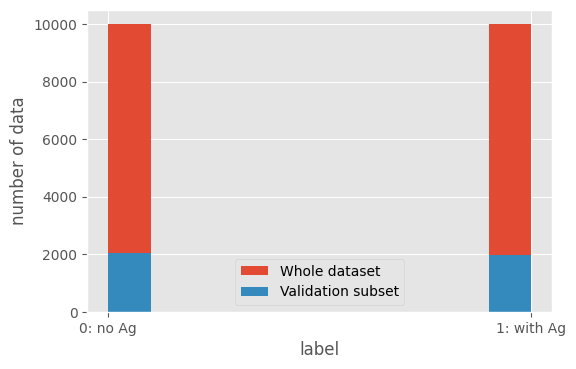

In [13]:
# plot distribution of downsampled data
plt.figure(dpi=100)
plt.hist(train_y_balanced, label='Whole dataset')
plt.hist(train_y_balanced[-len(train_y_balanced)//5:], label='Validation subset')
plt.xticks([0, 1], ['0: no Ag', '1: with Ag'])
plt.xlabel('label')
plt.ylabel('number of data')
plt.legend()
plt.show()

### Re-train the model

Now we can re-train the model with the balanced dataset. Simply change `train_x` and `train_y` to `train_x_balanced` and `train_y_balanced` in `model.fit()` and repeat all the steps in [1. Try out a network](#1.-Try-out-a-network). Note that, to avoid the influence of the initial model state (weights and biases) left by the previous training (such as the one trained with the imbalanced dataset), we have to first re-define and re-compile the model before calling `model.fit()`. A larger `epochs` can be used because we now have much fewer data. 


**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# set a random seed
tf.random.set_seed(0)

# re-define the model
model = Sequential()
model.add(Dense(64, input_dim=1000, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# re-compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# re-train the model
tic = time.time()
training_history_balanced = model.fit(train_x_balanced, train_y_balanced, 
                                      epochs=500, batch_size=256, validation_split=0.2)
print('run time: {:5.3f} s'.format(time.time() - tic))
    
# plot training history
plot_history(training_history_balanced)
```
    
</p>
</details>

In [14]:
# set a random seed
tf.random.set_seed(0)

# re-define the model
model = Sequential()
model.add(Dense(64, input_dim=1000, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# re-compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# re-train the model
tic = time.time()
training_history_balanced = model.fit(train_x_balanced, train_y_balanced, 
                                      epochs=500, batch_size=256, validation_split=0.2)
print('run time: {:5.3f} s'.format(time.time() - tic))

Epoch 1/500
63/63 [==============================] - 0s 4ms/step - loss: 0.6938 - accuracy: 0.5012 - val_loss: 0.6930 - val_accuracy: 0.5113
Epoch 2/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4999 - val_loss: 0.6932 - val_accuracy: 0.4888
Epoch 3/500
63/63 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5003 - val_loss: 0.6933 - val_accuracy: 0.4888
Epoch 4/500
63/63 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.5069 - val_loss: 0.6932 - val_accuracy: 0.4890
Epoch 5/500
63/63 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.5026 - val_loss: 0.6934 - val_accuracy: 0.4888
Epoch 6/500
63/63 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5028 - val_loss: 0.6933 - val_accuracy: 0.4888
Epoch 7/500
63/63 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5028 - val_loss: 0.6933 - val_accuracy: 0.4888
Epoch 8/500
6

Epoch 59/500
63/63 [==============================] - 0s 4ms/step - loss: 0.4209 - accuracy: 0.8231 - val_loss: 0.4320 - val_accuracy: 0.8102
Epoch 60/500
63/63 [==============================] - 0s 3ms/step - loss: 0.4038 - accuracy: 0.8406 - val_loss: 0.4088 - val_accuracy: 0.8390
Epoch 61/500
63/63 [==============================] - 0s 3ms/step - loss: 0.3919 - accuracy: 0.8463 - val_loss: 0.4050 - val_accuracy: 0.8353
Epoch 62/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3938 - accuracy: 0.8373 - val_loss: 0.4008 - val_accuracy: 0.8322
Epoch 63/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3771 - accuracy: 0.8510 - val_loss: 0.3833 - val_accuracy: 0.8475
Epoch 64/500
63/63 [==============================] - 0s 3ms/step - loss: 0.3757 - accuracy: 0.8496 - val_loss: 0.3810 - val_accuracy: 0.8445
Epoch 65/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3595 - accuracy: 0.8619 - val_loss: 0.3709 - val_accuracy: 0.8485
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.1613 - accuracy: 0.9441 - val_loss: 0.1689 - val_accuracy: 0.9402
Epoch 117/500
63/63 [==============================] - 0s 3ms/step - loss: 0.1583 - accuracy: 0.9453 - val_loss: 0.1649 - val_accuracy: 0.9420
Epoch 118/500
63/63 [==============================] - 0s 2ms/step - loss: 0.1630 - accuracy: 0.9408 - val_loss: 0.1649 - val_accuracy: 0.9400
Epoch 119/500
63/63 [==============================] - 0s 2ms/step - loss: 0.1654 - accuracy: 0.9394 - val_loss: 0.2097 - val_accuracy: 0.9140
Epoch 120/500
63/63 [==============================] - 0s 2ms/step - loss: 0.1716 - accuracy: 0.9349 - val_loss: 0.2132 - val_accuracy: 0.9062
Epoch 121/500
63/63 [==============================] - 0s 2ms/step - loss: 0.1643 - accuracy: 0.9396 - val_loss: 0.1557 - val_accuracy: 0.9460
Epoch 122/500
63/63 [==============================] - 0s 3ms/step - loss: 0.1554 - accuracy: 0.9448 - val_loss: 0.1557 - val_accuracy: 0.9463
Epoch 123/500

63/63 [==============================] - 0s 2ms/step - loss: 0.0863 - accuracy: 0.9718 - val_loss: 0.0824 - val_accuracy: 0.9707
Epoch 174/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0812 - accuracy: 0.9739 - val_loss: 0.0895 - val_accuracy: 0.9670
Epoch 175/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0808 - accuracy: 0.9727 - val_loss: 0.0839 - val_accuracy: 0.9705
Epoch 176/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0793 - accuracy: 0.9750 - val_loss: 0.0898 - val_accuracy: 0.9688
Epoch 177/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0875 - accuracy: 0.9705 - val_loss: 0.1409 - val_accuracy: 0.9392
Epoch 178/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0870 - accuracy: 0.9706 - val_loss: 0.1108 - val_accuracy: 0.9588
Epoch 179/500
63/63 [==============================] - 0s 2ms/step - loss: 0.1032 - accuracy: 0.9609 - val_loss: 0.0975 - val_accuracy: 0.9647
Epoch 180/500

63/63 [==============================] - 0s 2ms/step - loss: 0.0669 - accuracy: 0.9776 - val_loss: 0.0596 - val_accuracy: 0.9800
Epoch 231/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0640 - accuracy: 0.9771 - val_loss: 0.0594 - val_accuracy: 0.9800
Epoch 232/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0576 - accuracy: 0.9804 - val_loss: 0.0634 - val_accuracy: 0.9790
Epoch 233/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0708 - accuracy: 0.9747 - val_loss: 0.1489 - val_accuracy: 0.9373
Epoch 234/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0672 - accuracy: 0.9765 - val_loss: 0.0553 - val_accuracy: 0.9812
Epoch 235/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0545 - accuracy: 0.9824 - val_loss: 0.0558 - val_accuracy: 0.9815
Epoch 236/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0726 - accuracy: 0.9750 - val_loss: 0.0780 - val_accuracy: 0.9697
Epoch 237/500

63/63 [==============================] - 0s 2ms/step - loss: 0.0563 - accuracy: 0.9793 - val_loss: 0.0591 - val_accuracy: 0.9765
Epoch 288/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0520 - accuracy: 0.9822 - val_loss: 0.2703 - val_accuracy: 0.8823
Epoch 289/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0818 - accuracy: 0.9681 - val_loss: 0.0465 - val_accuracy: 0.9855
Epoch 290/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0705 - accuracy: 0.9742 - val_loss: 0.0473 - val_accuracy: 0.9830
Epoch 291/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0493 - accuracy: 0.9834 - val_loss: 0.0490 - val_accuracy: 0.9847
Epoch 292/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0492 - accuracy: 0.9827 - val_loss: 0.0471 - val_accuracy: 0.9833
Epoch 293/500
63/63 [==============================] - 0s 3ms/step - loss: 0.0468 - accuracy: 0.9844 - val_loss: 0.0486 - val_accuracy: 0.9820
Epoch 294/500

63/63 [==============================] - 0s 3ms/step - loss: 0.0516 - accuracy: 0.9812 - val_loss: 0.0470 - val_accuracy: 0.9845
Epoch 345/500
63/63 [==============================] - 0s 4ms/step - loss: 0.0518 - accuracy: 0.9806 - val_loss: 0.1700 - val_accuracy: 0.9340
Epoch 346/500
63/63 [==============================] - 0s 3ms/step - loss: 0.3147 - accuracy: 0.9007 - val_loss: 0.0475 - val_accuracy: 0.9827
Epoch 347/500
63/63 [==============================] - 0s 3ms/step - loss: 0.0519 - accuracy: 0.9812 - val_loss: 0.0502 - val_accuracy: 0.9803
Epoch 348/500
63/63 [==============================] - 0s 3ms/step - loss: 0.0448 - accuracy: 0.9852 - val_loss: 0.0434 - val_accuracy: 0.9875
Epoch 349/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0498 - accuracy: 0.9813 - val_loss: 0.0520 - val_accuracy: 0.9787
Epoch 350/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0419 - accuracy: 0.9859 - val_loss: 0.0518 - val_accuracy: 0.9793
Epoch 351/500

63/63 [==============================] - 0s 2ms/step - loss: 0.0438 - accuracy: 0.9851 - val_loss: 0.0626 - val_accuracy: 0.9740
Epoch 402/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0388 - accuracy: 0.9860 - val_loss: 0.0593 - val_accuracy: 0.9753
Epoch 403/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0424 - accuracy: 0.9860 - val_loss: 0.0444 - val_accuracy: 0.9843
Epoch 404/500
63/63 [==============================] - 0s 3ms/step - loss: 0.0382 - accuracy: 0.9872 - val_loss: 0.0522 - val_accuracy: 0.9803
Epoch 405/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0489 - accuracy: 0.9826 - val_loss: 0.0484 - val_accuracy: 0.9808
Epoch 406/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0399 - accuracy: 0.9866 - val_loss: 0.0425 - val_accuracy: 0.9872
Epoch 407/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0421 - accuracy: 0.9854 - val_loss: 0.0454 - val_accuracy: 0.9845
Epoch 408/500

63/63 [==============================] - 0s 2ms/step - loss: 0.0360 - accuracy: 0.9880 - val_loss: 0.0414 - val_accuracy: 0.9865
Epoch 459/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0375 - accuracy: 0.9869 - val_loss: 0.0410 - val_accuracy: 0.9870
Epoch 460/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0422 - accuracy: 0.9857 - val_loss: 0.0564 - val_accuracy: 0.9778
Epoch 461/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0390 - accuracy: 0.9866 - val_loss: 0.0479 - val_accuracy: 0.9808
Epoch 462/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0717 - accuracy: 0.9726 - val_loss: 0.0462 - val_accuracy: 0.9818
Epoch 463/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0504 - accuracy: 0.9818 - val_loss: 0.0581 - val_accuracy: 0.9772
Epoch 464/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0442 - accuracy: 0.9844 - val_loss: 0.0410 - val_accuracy: 0.9872
Epoch 465/500

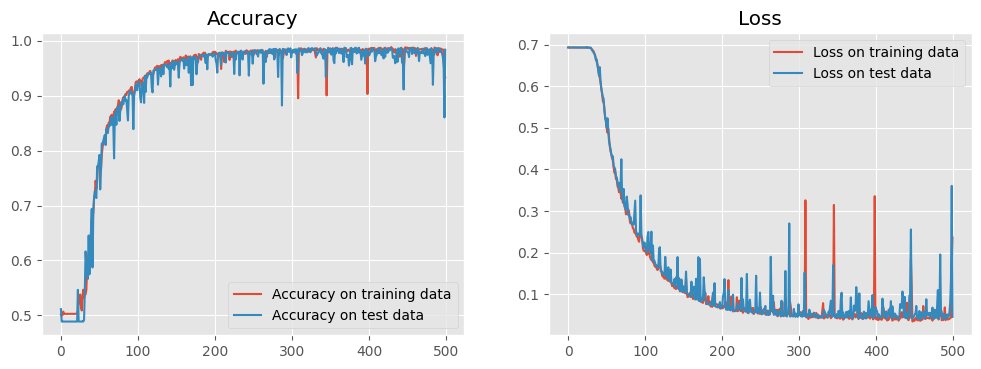

In [15]:
# plot training history
plot_history(training_history_balanced)

### Early stopping

The droput has brought the training and validation losses closer to one another. However we also see that there are large oscillations in the validation performance. This is realted to the rather small training and validation set sizes. How can we make sure that we recover the model with the best performance on validation?

We can use a **callback** to tell the algorithm to save the model every time there is a new best validation loss. We can then also tell the training algorithm to cease if the validation loss has not improved for _n_ steps; below we set up a callback to monitor the `val_accuracy` and to stop if this has not improved for 20 steps, then restore the weights of the best model. 

```
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)
```

The callbacks are then specified as a list of all callbacks you defined and passed to the `fit` function _via_ the keyword `callbacks`.

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# set a random seed
tf.random.set_seed(0)

# re-define the model
model = Sequential()
model.add(Dense(64, input_dim=1000, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# re-compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# define the callback
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)

# re-train the model
tic = time.time()
training_history_balanced = model.fit(train_x_balanced, train_y_balanced, 
                                      epochs=500, batch_size=256, validation_split=0.2,
                                      callbacks=[callback])
print('run time: {:5.3f} s'.format(time.time() - tic))
    
# plot training history
plot_history(training_history_balanced)
```
    
</p>
</details>

In [16]:
# set a random seed
tf.random.set_seed(0)

# re-define the model
model = Sequential()
model.add(Dense(64, input_dim=1000, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# re-compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# define the callback
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)

# re-train the model
tic = time.time()
training_history_balanced = model.fit(train_x_balanced, train_y_balanced, 
                                      epochs=500, batch_size=256, validation_split=0.2,
                                      callbacks=[callback])
print('run time: {:5.3f} s'.format(time.time() - tic))

Epoch 1/500
63/63 [==============================] - 0s 4ms/step - loss: 0.6938 - accuracy: 0.5012 - val_loss: 0.6930 - val_accuracy: 0.5113
Epoch 2/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4999 - val_loss: 0.6932 - val_accuracy: 0.4888
Epoch 3/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5003 - val_loss: 0.6933 - val_accuracy: 0.4888
Epoch 4/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5069 - val_loss: 0.6932 - val_accuracy: 0.4890
Epoch 5/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5026 - val_loss: 0.6934 - val_accuracy: 0.4888
Epoch 6/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5028 - val_loss: 0.6933 - val_accuracy: 0.4888
Epoch 7/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5028 - val_loss: 0.6933 - val_accuracy: 0.4888
Epoch 8/500
6

Epoch 59/500
63/63 [==============================] - 0s 2ms/step - loss: 0.4209 - accuracy: 0.8231 - val_loss: 0.4320 - val_accuracy: 0.8102
Epoch 60/500
63/63 [==============================] - 0s 2ms/step - loss: 0.4038 - accuracy: 0.8406 - val_loss: 0.4088 - val_accuracy: 0.8390
Epoch 61/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3919 - accuracy: 0.8463 - val_loss: 0.4050 - val_accuracy: 0.8353
Epoch 62/500
63/63 [==============================] - 0s 3ms/step - loss: 0.3938 - accuracy: 0.8373 - val_loss: 0.4008 - val_accuracy: 0.8322
Epoch 63/500
63/63 [==============================] - 0s 3ms/step - loss: 0.3771 - accuracy: 0.8510 - val_loss: 0.3833 - val_accuracy: 0.8475
Epoch 64/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3757 - accuracy: 0.8496 - val_loss: 0.3810 - val_accuracy: 0.8445
Epoch 65/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3595 - accuracy: 0.8619 - val_loss: 0.3709 - val_accuracy: 0.8485
Epoch 

63/63 [==============================] - 0s 3ms/step - loss: 0.1613 - accuracy: 0.9441 - val_loss: 0.1689 - val_accuracy: 0.9402
Epoch 117/500
63/63 [==============================] - 0s 3ms/step - loss: 0.1583 - accuracy: 0.9453 - val_loss: 0.1649 - val_accuracy: 0.9420
Epoch 118/500
63/63 [==============================] - 0s 2ms/step - loss: 0.1630 - accuracy: 0.9408 - val_loss: 0.1649 - val_accuracy: 0.9400
Epoch 119/500
63/63 [==============================] - 0s 2ms/step - loss: 0.1654 - accuracy: 0.9394 - val_loss: 0.2097 - val_accuracy: 0.9140
Epoch 120/500
63/63 [==============================] - 0s 2ms/step - loss: 0.1716 - accuracy: 0.9349 - val_loss: 0.2132 - val_accuracy: 0.9062
Epoch 121/500
63/63 [==============================] - 0s 3ms/step - loss: 0.1643 - accuracy: 0.9396 - val_loss: 0.1557 - val_accuracy: 0.9460
Epoch 122/500
63/63 [==============================] - 0s 3ms/step - loss: 0.1554 - accuracy: 0.9448 - val_loss: 0.1557 - val_accuracy: 0.9463
Epoch 123/500

63/63 [==============================] - 0s 2ms/step - loss: 0.0863 - accuracy: 0.9718 - val_loss: 0.0824 - val_accuracy: 0.9707
Epoch 174/500
63/63 [==============================] - 0s 3ms/step - loss: 0.0812 - accuracy: 0.9739 - val_loss: 0.0895 - val_accuracy: 0.9670
Epoch 175/500
63/63 [==============================] - 0s 3ms/step - loss: 0.0808 - accuracy: 0.9727 - val_loss: 0.0839 - val_accuracy: 0.9705
Epoch 176/500
63/63 [==============================] - 0s 3ms/step - loss: 0.0793 - accuracy: 0.9750 - val_loss: 0.0898 - val_accuracy: 0.9688
Epoch 177/500
63/63 [==============================] - 0s 3ms/step - loss: 0.0875 - accuracy: 0.9705 - val_loss: 0.1409 - val_accuracy: 0.9392
Epoch 178/500
63/63 [==============================] - 0s 3ms/step - loss: 0.0870 - accuracy: 0.9706 - val_loss: 0.1108 - val_accuracy: 0.9588
Epoch 179/500
63/63 [==============================] - 0s 3ms/step - loss: 0.1032 - accuracy: 0.9609 - val_loss: 0.0975 - val_accuracy: 0.9647
Epoch 180/500

63/63 [==============================] - 0s 2ms/step - loss: 0.0669 - accuracy: 0.9776 - val_loss: 0.0596 - val_accuracy: 0.9800
Epoch 231/500
63/63 [==============================] - 0s 3ms/step - loss: 0.0640 - accuracy: 0.9771 - val_loss: 0.0594 - val_accuracy: 0.9800
Epoch 232/500
63/63 [==============================] - 0s 3ms/step - loss: 0.0576 - accuracy: 0.9804 - val_loss: 0.0634 - val_accuracy: 0.9790
Epoch 233/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0708 - accuracy: 0.9747 - val_loss: 0.1489 - val_accuracy: 0.9373
Epoch 234/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0672 - accuracy: 0.9765 - val_loss: 0.0553 - val_accuracy: 0.9812
Epoch 235/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0545 - accuracy: 0.9824 - val_loss: 0.0558 - val_accuracy: 0.9815
Epoch 236/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0726 - accuracy: 0.9750 - val_loss: 0.0780 - val_accuracy: 0.9697
Epoch 237/500

63/63 [==============================] - 0s 2ms/step - loss: 0.0563 - accuracy: 0.9793 - val_loss: 0.0591 - val_accuracy: 0.9765
Epoch 288/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0520 - accuracy: 0.9822 - val_loss: 0.2703 - val_accuracy: 0.8823
Epoch 289/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0818 - accuracy: 0.9681 - val_loss: 0.0465 - val_accuracy: 0.9855
Epoch 290/500
63/63 [==============================] - 0s 3ms/step - loss: 0.0705 - accuracy: 0.9742 - val_loss: 0.0473 - val_accuracy: 0.9830
Epoch 291/500
63/63 [==============================] - 0s 3ms/step - loss: 0.0493 - accuracy: 0.9834 - val_loss: 0.0490 - val_accuracy: 0.9847
Epoch 292/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0492 - accuracy: 0.9827 - val_loss: 0.0471 - val_accuracy: 0.9833
Epoch 293/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0468 - accuracy: 0.9844 - val_loss: 0.0486 - val_accuracy: 0.9820
Epoch 294/500

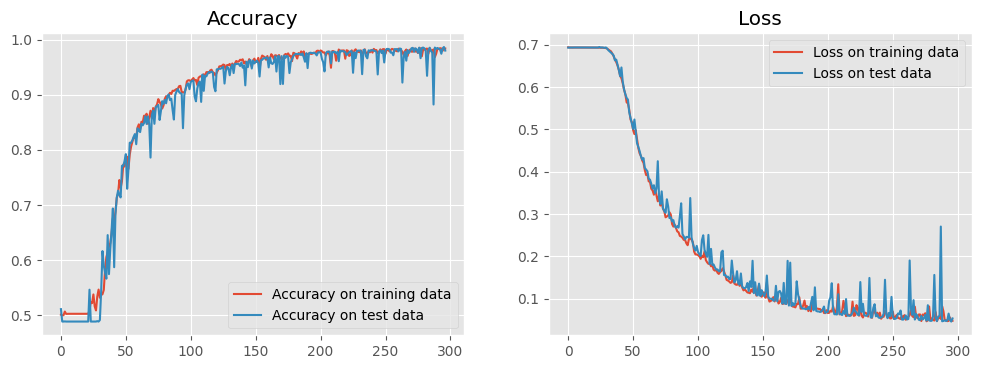

In [17]:
# plot training history
plot_history(training_history_balanced)

---

## Exercises

Build a DNN to detect the presence of all the elements. To do this, you may go through the following steps:

1. Find all the elements appearing in the dataset; the answer will be `['Zn', 'Sb', 'Si', 'Fe', 'Ag', 'Cu', 'Bi']`.
2. Balance the dataset: if one of the elements appears much less times than the others, it is better to ignore it. Doing everything correctly, you will find the number of samples containing each element as shown in the following table. Therefore, we may ignore Ag in this network.


|  Element | # Samples |
|---|---|
|Zn| 51174|  
|Sb| 51132|  
|Si| 50909| 
|Fe| 50764|
|Ag| 10000|
|Cu| 50945|
|Bi| 50784|
    
3. Do one-hot encoding for the element list `['Zn', 'Sb', 'Si', 'Fe', 'Cu', 'Bi']`; if a sample contains Fe and Sb, e.g., the one-hot vector for this sample will be `[0, 1, 0, 1, 0, 0]`.
4. Build and train a DNN (with an input size of 150 and an output size of 6) to detect the presence of the six elements.

If doing everything correctly, you will find that the overall accuracy is around 60%. However, the model is not garbage. If we evaluate the accuracy for each element, we will find that the accracy for some of elements is nearly 0 while for the others nearly 100%. This means the dataset is agnostic to these elements, which lower the overall accuracy, but the model can still be used to predict the other elements with  high accuracy.

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
##################
###### data ######
##################
# output
element_list = ['Zn', 'Sb', 'Si', 'Fe', 'Cu', 'Bi']
train_y = []
for element in element_list:
    train_y.append(np.array([element in elements for elements in df['Elements']]).astype(int))
train_y = np.transpose(np.array(train_y))

# print data shapes
print("Shape of input: %s" % str(train_x.shape))
print("Shape of output: %s" % str(train_y.shape))


###################
###### model ######
###################
model = Sequential()
model.add(Dense(64, input_dim=1000, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(6, activation='sigmoid'))

# print model summary
model.summary()

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


###################
###### train ######
###################
# train the model
training_history = model.fit(train_x, train_y, epochs=100, batch_size=256, 
                             validation_split=0.2)
# plot training history
plot_history(training_history)


#####################
###### predict ######
#####################
pred_y = model.predict(train_x)

# show overall accuracy and accuracy for each element
def binary_accuracy(pred, ground_truth):
    return np.where(np.abs(pred - ground_truth) < .1)[0].size / pred.size

print(f'Overall accuracy = {binary_accuracy(pred_y, train_y)}')
for i, element in enumerate(element_list):
    print(f'Accuracy for {element} = {binary_accuracy(pred_y[:, i], train_y[:, i])}')
```
    
</p>
</details>

Shape of input: (138613, 1000)
Shape of output: (138613, 6)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                64064     
_________________________________________________________________
dense_10 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 102       
Total params: 65,206
Trainable params: 65,206
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
434/434 [==============================] - 1s 2ms/step - loss: 0.6476 - accuracy: 0.2828 - val_loss: 0.6136 - val_accuracy: 0.4884
Epoch 2/100
434/434 [==============================] - 1s 2ms/step - loss: 0.5356 - accuracy: 0.5438 - val_loss: 0.4728 - val_accuracy: 0.5598
Epoch 3/100
434/434 [=============

434/434 [==============================] - 1s 2ms/step - loss: 0.2229 - accuracy: 0.6095 - val_loss: 0.2237 - val_accuracy: 0.6165
Epoch 53/100
434/434 [==============================] - 1s 2ms/step - loss: 0.2231 - accuracy: 0.6088 - val_loss: 0.2236 - val_accuracy: 0.6143
Epoch 54/100
434/434 [==============================] - 1s 2ms/step - loss: 0.2227 - accuracy: 0.6103 - val_loss: 0.2227 - val_accuracy: 0.6343
Epoch 55/100
434/434 [==============================] - 1s 2ms/step - loss: 0.2228 - accuracy: 0.6118 - val_loss: 0.2221 - val_accuracy: 0.6080
Epoch 56/100
434/434 [==============================] - 1s 2ms/step - loss: 0.2228 - accuracy: 0.6093 - val_loss: 0.2234 - val_accuracy: 0.6092
Epoch 57/100
434/434 [==============================] - 1s 2ms/step - loss: 0.2227 - accuracy: 0.6077 - val_loss: 0.2236 - val_accuracy: 0.6048
Epoch 58/100
434/434 [==============================] - 1s 2ms/step - loss: 0.2227 - accuracy: 0.6099 - val_loss: 0.2236 - val_accuracy: 0.5932
Epoch

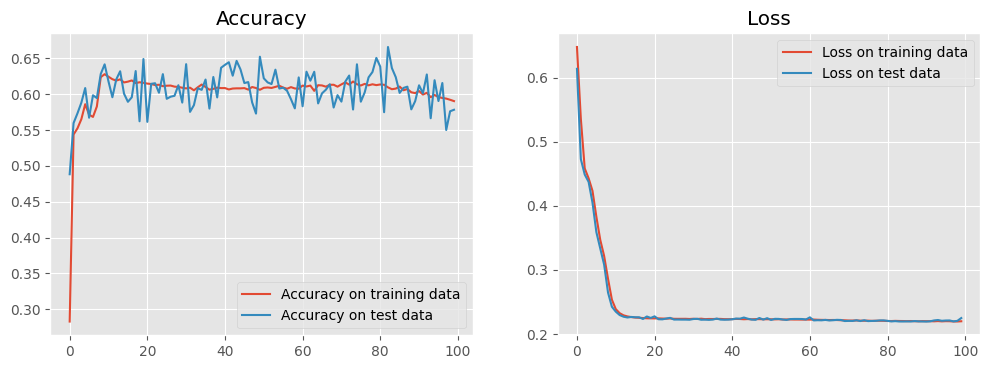

Overall accuracy = 0.6604635447853616
Accuracy for Zn = 0.9769429995743545
Accuracy for Sb = 0.9999855713389076
Accuracy for Si = 0.0
Accuracy for Fe = 0.9858671264600002
Accuracy for Cu = 0.0
Accuracy for Bi = 0.9999855713389076


In [18]:
##################
###### data ######
##################
# output
element_list = ['Zn', 'Sb', 'Si', 'Fe', 'Cu', 'Bi']
train_y = []
for element in element_list:
    train_y.append(np.array([element in elements for elements in df['Elements']]).astype(int))
train_y = np.transpose(np.array(train_y))

# print data shapes
print("Shape of input: %s" % str(train_x.shape))
print("Shape of output: %s" % str(train_y.shape))


###################
###### model ######
###################
model = Sequential()
model.add(Dense(64, input_dim=1000, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(6, activation='sigmoid'))

# print model summary
model.summary()

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


###################
###### train ######
###################
# train the model
training_history = model.fit(train_x, train_y, epochs=100, batch_size=256, 
                             validation_split=0.2)
# plot training history
plot_history(training_history)


#####################
###### predict ######
#####################
pred_y = model.predict(train_x)

# show overall accuracy and accuracy for each element
def binary_accuracy(pred, ground_truth):
    return np.where(np.abs(pred - ground_truth) < .1)[0].size / pred.size

print(f'Overall accuracy = {binary_accuracy(pred_y, train_y)}')
for i, element in enumerate(element_list):
    print(f'Accuracy for {element} = {binary_accuracy(pred_y[:, i], train_y[:, i])}')